# CNN-LSTM Hybrid for Decoding EEG

In this notebook, we will explore how a Resnet-LSTM performs on EEG data, which has both spatial and temporal components.

In [1]:
from resnetLSTM import *

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch import Tensor
from typing import Type
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import random

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
if torch.cuda.is_available():
  device = torch.device('cuda')
elif torch.backends.mps.is_available():
  device = torch.device('mps')
else:
  device = torch.device('cpu')

print("Using", device)

Using cuda


In [3]:
# Load training data
X_train_valid = np.load("C:/Users/awong/OneDrive/Desktop/PythonScripts/C147HW/Final Project/project_data/project/X_train_valid.npy")
y_train_valid = np.load("C:/Users/awong/OneDrive/Desktop/PythonScripts/C147HW/Final Project/project_data/project/y_train_valid.npy")
y_train_valid = y_train_valid - 769
person_train_valid = np.load("C:/Users/awong/OneDrive/Desktop/PythonScripts/C147HW/Final Project/project_data/project/person_train_valid.npy")

# Load test data
X_test = np.load("C:/Users/awong/OneDrive/Desktop/PythonScripts/C147HW/Final Project/project_data/project/X_test.npy")
y_test = np.load("C:/Users/awong/OneDrive/Desktop/PythonScripts/C147HW/Final Project/project_data/project/y_test.npy")
y_test = y_test - 769
person_test = np.load("C:/Users/awong/OneDrive/Desktop/PythonScripts/C147HW/Final Project/project_data/project/person_test.npy")

# Print shapes
print(X_train_valid.shape)
print(y_train_valid.shape)
print(person_train_valid.shape)
print(X_test.shape)
print(y_test.shape)
print(person_test.shape)

(2115, 22, 1000)
(2115,)
(2115, 1)
(443, 22, 1000)
(443,)
(443, 1)


In [4]:

## Preprocessing the dataset

X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep = test_data_prep(X_test) 

## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 1000, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
x_train = torch.tensor(x_train).detach().float().to(device)
x_valid = torch.tensor(x_valid).detach().float().to(device)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

# Converting the labels to categorical variables for multiclass classification
y_train, y_valid, y_test = torch.tensor(y_train).to(device), torch.tensor(y_valid).to(device), torch.tensor(y_test).to(device)
y_train = nn.functional.one_hot(y_train.long(), 4)
y_valid = nn.functional.one_hot(y_valid.long(), 4)
y_test = nn.functional.one_hot(y_test.long(), 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 2,3)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 2,3)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 2,3)
x_test = torch.tensor(x_test).detach().float().to(device)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of X after trimming: (2115, 22, 800)
Shape of X after maxpooling: (2115, 22, 400)
Shape of X after averaging+noise and concatenating: (4230, 22, 400)
Shape of X after subsampling and concatenating: (8460, 22, 400)
Shape of Y: (8460,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of training set: torch.Size([7460, 22, 400])
Shape of validation set: torch.Size([1000, 22, 400])
Shape of training labels: (7460,)
Shape of validation labels: (1000,)
Shape of training labels after categorical conversion: torch.Size([7460, 4])
Shape of validation labels after categorical conversion: torch.Size([1000, 4])
Shape of test labels after categorical conversion: torch.Size([443, 4])
Shape of training set after adding width info: torch.Size([7460, 22, 400, 1])
Shape of validation set after adding width info: torch.Size([1000, 22, 400, 1])
Shape of test set after adding width info: (443, 22, 400, 1)
Shape of training set after dimension reshaping: torc

In [5]:
# #Test random sample function
bsz = 10
x_train_sample, y_train_sample = sample(x_train, y_train, bsz)
print(len(x_train_sample), len(y_train_sample))

10 10


# Build Resnet-18
https://debuggercafe.com/implementing-resnet18-in-pytorch-from-scratch/

Added these additional imports:

from torch import Tensor

from typing import Type

Since the inputs are 22x1000, we can use 3x3 filters with pad=1 and stride=1

In [6]:
model = ResNetLSTM(img_channels=1, num_layers=18, block=BasicBlock, num_classes=4, dropout=0.6).to(device)
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

c:\Users\awong\anaconda3\envs\c147proj\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


ResNetLSTM(
  (conv1): Conv2d(1, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(48, 48, kernel_size=(22, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0, inplace=True)
  (res1): BasicBlock(
    (conv1): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.6, inplace=False)
    (elu): ELU(alpha=1.0, inplace=True)
    (conv2): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=same, bias=False)
    (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.6, inplace=False)
    (shortcut): Identity()
  )
  (res2): BasicBlock(
    (conv1):

In [7]:
# Choose Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

## Train the ResNet on the entire data.

In [9]:
train_history, val_history = np.array([]), np.array([])
train_loss_hist, val_loss_hist = np.array([]), np.array([])

with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0
    bsz = 100
    num_epochs = 100
    iteration = 0
    total_it = num_epochs*int(x_train.shape[0]/bsz)
    for epoch_idx in tqdm(range(num_epochs)):
        # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
        model.train()
        train_count = 0
        train_correct_count = 0
        for i in range(int(x_train.shape[0]/bsz)):
            iteration+=1
            optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
            train_x, train_y = sample(x_train, y_train, bsz)
            logits = model(train_x) #bszx4x1x4
            
            logits = nn.functional.softmax(logits, dim=1)
            loss = criterion(logits.float(), train_y.float())

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                #y_hat = torch.mean(logits, dim = 2)
                y_hat = torch.argmax(logits, dim=1)
                train_correct_count = torch.sum(y_hat == torch.argmax(train_y, dim=1))
                train_count = train_x.size(0)
                train_count = float(train_count)
            #print(f'(Iteration {iteration}/{total_it})Training Accuracy: ', (train_correct_count/train_count).item(), '. Loss: ', loss.item())
        

        train_acc = train_correct_count / train_count

        model.eval()
        val_count = 0
        val_correct_count = 0
        with torch.no_grad():
            val_x = x_valid
            val_y = y_valid
            logits = model(val_x).detach()
            logits = nn.functional.softmax(logits)
            val_loss = criterion(logits.float(), val_y.float())
            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=1)
                val_correct_count = torch.sum(y_hat == torch.argmax(val_y, dim=1))
                val_count = float(val_x.size(0))
        val_acc = val_correct_count / y_valid.shape[0]

        print(f'Epoch {epoch_idx+1} Finished!!!')
        print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))
        print('Train loss: {:.3f}, Val loss: {:.3f}'.format(loss, val_loss))

        train_history = np.append(train_history, train_acc.item())
        val_history = np.append(val_history, val_acc.item())
        train_loss_hist = np.append(train_loss_hist, loss.item())
        val_loss_hist = np.append(val_loss_hist, val_loss.item())

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), best_model_params_path)
    
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\awong\AppData\Local\Temp\ipykernel_14752\2130566024.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)
  1%|          | 1/100 [01:06<1:48:56, 66.03s/it]

Epoch 1 Finished!!!
Train acc: 0.360, Val acc: 0.430
Train loss: 1.356, Val loss: 1.348
Epoch 2 Finished!!!


  2%|▏         | 2/100 [01:37<1:14:42, 45.74s/it]

Train acc: 0.440, Val acc: 0.448
Train loss: 1.296, Val loss: 1.299
Epoch 3 Finished!!!


  3%|▎         | 3/100 [02:08<1:03:02, 38.99s/it]

Train acc: 0.530, Val acc: 0.479
Train loss: 1.238, Val loss: 1.265
Epoch 4 Finished!!!


  4%|▍         | 4/100 [02:39<57:22, 35.86s/it]  

Train acc: 0.470, Val acc: 0.475
Train loss: 1.253, Val loss: 1.257
Epoch 5 Finished!!!


  5%|▌         | 5/100 [03:08<53:03, 33.51s/it]

Train acc: 0.580, Val acc: 0.520
Train loss: 1.192, Val loss: 1.229
Epoch 6 Finished!!!


  6%|▌         | 6/100 [03:34<48:28, 30.94s/it]

Train acc: 0.480, Val acc: 0.511
Train loss: 1.252, Val loss: 1.231
Epoch 7 Finished!!!


  7%|▋         | 7/100 [04:00<45:26, 29.32s/it]

Train acc: 0.570, Val acc: 0.527
Train loss: 1.211, Val loss: 1.215
Epoch 8 Finished!!!


  8%|▊         | 8/100 [04:26<43:21, 28.27s/it]

Train acc: 0.600, Val acc: 0.517
Train loss: 1.158, Val loss: 1.221
Epoch 9 Finished!!!


  9%|▉         | 9/100 [04:52<41:49, 27.58s/it]

Train acc: 0.600, Val acc: 0.535
Train loss: 1.149, Val loss: 1.199
Epoch 10 Finished!!!


 10%|█         | 10/100 [05:19<40:39, 27.11s/it]

Train acc: 0.590, Val acc: 0.539
Train loss: 1.171, Val loss: 1.200
Epoch 11 Finished!!!


 11%|█         | 11/100 [05:45<39:44, 26.80s/it]

Train acc: 0.580, Val acc: 0.547
Train loss: 1.169, Val loss: 1.190
Epoch 12 Finished!!!


 12%|█▏        | 12/100 [06:11<38:59, 26.58s/it]

Train acc: 0.560, Val acc: 0.557
Train loss: 1.197, Val loss: 1.189
Epoch 13 Finished!!!


 13%|█▎        | 13/100 [06:37<38:20, 26.44s/it]

Train acc: 0.560, Val acc: 0.564
Train loss: 1.192, Val loss: 1.174
Epoch 14 Finished!!!


 14%|█▍        | 14/100 [07:03<37:51, 26.41s/it]

Train acc: 0.650, Val acc: 0.592
Train loss: 1.115, Val loss: 1.158
Epoch 15 Finished!!!


 15%|█▌        | 15/100 [07:30<37:27, 26.44s/it]

Train acc: 0.640, Val acc: 0.554
Train loss: 1.103, Val loss: 1.176
Epoch 16 Finished!!!


 16%|█▌        | 16/100 [07:56<36:58, 26.42s/it]

Train acc: 0.570, Val acc: 0.563
Train loss: 1.183, Val loss: 1.168
Epoch 17 Finished!!!


 17%|█▋        | 17/100 [08:22<36:25, 26.33s/it]

Train acc: 0.570, Val acc: 0.600
Train loss: 1.194, Val loss: 1.143
Epoch 18 Finished!!!


 18%|█▊        | 18/100 [08:49<36:09, 26.46s/it]

Train acc: 0.630, Val acc: 0.606
Train loss: 1.110, Val loss: 1.143
Epoch 19 Finished!!!


 19%|█▉        | 19/100 [09:15<35:40, 26.42s/it]

Train acc: 0.510, Val acc: 0.580
Train loss: 1.206, Val loss: 1.160
Epoch 20 Finished!!!


 20%|██        | 20/100 [09:41<35:08, 26.35s/it]

Train acc: 0.570, Val acc: 0.605
Train loss: 1.167, Val loss: 1.140
Epoch 21 Finished!!!


 21%|██        | 21/100 [10:08<34:38, 26.31s/it]

Train acc: 0.590, Val acc: 0.601
Train loss: 1.147, Val loss: 1.141
Epoch 22 Finished!!!


 22%|██▏       | 22/100 [10:34<34:08, 26.27s/it]

Train acc: 0.580, Val acc: 0.605
Train loss: 1.143, Val loss: 1.142
Epoch 23 Finished!!!


 23%|██▎       | 23/100 [11:00<33:40, 26.24s/it]

Train acc: 0.520, Val acc: 0.596
Train loss: 1.208, Val loss: 1.138
Epoch 24 Finished!!!


 24%|██▍       | 24/100 [11:26<33:12, 26.22s/it]

Train acc: 0.640, Val acc: 0.591
Train loss: 1.104, Val loss: 1.147
Epoch 25 Finished!!!


 25%|██▌       | 25/100 [11:52<32:45, 26.21s/it]

Train acc: 0.730, Val acc: 0.641
Train loss: 1.019, Val loss: 1.100
Epoch 26 Finished!!!


 26%|██▌       | 26/100 [12:19<32:19, 26.21s/it]

Train acc: 0.620, Val acc: 0.609
Train loss: 1.130, Val loss: 1.129
Epoch 27 Finished!!!


 27%|██▋       | 27/100 [12:45<31:54, 26.22s/it]

Train acc: 0.630, Val acc: 0.660
Train loss: 1.108, Val loss: 1.087
Epoch 28 Finished!!!


 28%|██▊       | 28/100 [13:11<31:27, 26.22s/it]

Train acc: 0.670, Val acc: 0.637
Train loss: 1.081, Val loss: 1.103
Epoch 29 Finished!!!


 29%|██▉       | 29/100 [13:38<31:08, 26.31s/it]

Train acc: 0.690, Val acc: 0.659
Train loss: 1.076, Val loss: 1.091
Epoch 30 Finished!!!


 30%|███       | 30/100 [14:04<30:45, 26.37s/it]

Train acc: 0.750, Val acc: 0.605
Train loss: 0.990, Val loss: 1.128
Epoch 31 Finished!!!


 31%|███       | 31/100 [14:30<30:18, 26.35s/it]

Train acc: 0.680, Val acc: 0.659
Train loss: 1.074, Val loss: 1.095
Epoch 32 Finished!!!


 32%|███▏      | 32/100 [14:57<29:50, 26.33s/it]

Train acc: 0.630, Val acc: 0.631
Train loss: 1.092, Val loss: 1.104
Epoch 33 Finished!!!


 33%|███▎      | 33/100 [15:23<29:23, 26.32s/it]

Train acc: 0.640, Val acc: 0.651
Train loss: 1.096, Val loss: 1.097
Epoch 34 Finished!!!


 34%|███▍      | 34/100 [15:49<28:55, 26.30s/it]

Train acc: 0.740, Val acc: 0.673
Train loss: 1.008, Val loss: 1.072
Epoch 35 Finished!!!


 35%|███▌      | 35/100 [16:15<28:27, 26.27s/it]

Train acc: 0.730, Val acc: 0.671
Train loss: 1.023, Val loss: 1.075
Epoch 36 Finished!!!


 36%|███▌      | 36/100 [16:42<28:00, 26.26s/it]

Train acc: 0.720, Val acc: 0.691
Train loss: 1.018, Val loss: 1.055
Epoch 37 Finished!!!


 37%|███▋      | 37/100 [17:08<27:33, 26.25s/it]

Train acc: 0.770, Val acc: 0.684
Train loss: 0.995, Val loss: 1.063
Epoch 38 Finished!!!


 38%|███▊      | 38/100 [17:34<27:07, 26.24s/it]

Train acc: 0.720, Val acc: 0.711
Train loss: 1.042, Val loss: 1.043
Epoch 39 Finished!!!


 39%|███▉      | 39/100 [18:00<26:40, 26.24s/it]

Train acc: 0.740, Val acc: 0.699
Train loss: 1.009, Val loss: 1.047
Epoch 40 Finished!!!


 40%|████      | 40/100 [18:27<26:14, 26.24s/it]

Train acc: 0.660, Val acc: 0.699
Train loss: 1.086, Val loss: 1.046
Epoch 41 Finished!!!


 41%|████      | 41/100 [18:53<25:48, 26.24s/it]

Train acc: 0.720, Val acc: 0.697
Train loss: 1.026, Val loss: 1.050
Epoch 42 Finished!!!


 42%|████▏     | 42/100 [19:19<25:22, 26.25s/it]

Train acc: 0.850, Val acc: 0.724
Train loss: 0.924, Val loss: 1.024
Epoch 43 Finished!!!


 43%|████▎     | 43/100 [19:45<24:55, 26.24s/it]

Train acc: 0.730, Val acc: 0.724
Train loss: 1.002, Val loss: 1.027
Epoch 44 Finished!!!


 44%|████▍     | 44/100 [20:11<24:28, 26.22s/it]

Train acc: 0.740, Val acc: 0.724
Train loss: 1.014, Val loss: 1.025
Epoch 45 Finished!!!


 45%|████▌     | 45/100 [20:38<24:01, 26.21s/it]

Train acc: 0.810, Val acc: 0.723
Train loss: 0.939, Val loss: 1.026
Epoch 46 Finished!!!


 46%|████▌     | 46/100 [21:04<23:35, 26.21s/it]

Train acc: 0.660, Val acc: 0.687
Train loss: 1.090, Val loss: 1.061
Epoch 47 Finished!!!


 47%|████▋     | 47/100 [21:30<23:08, 26.20s/it]

Train acc: 0.750, Val acc: 0.729
Train loss: 1.001, Val loss: 1.020
Epoch 48 Finished!!!


 48%|████▊     | 48/100 [21:56<22:41, 26.19s/it]

Train acc: 0.800, Val acc: 0.726
Train loss: 0.962, Val loss: 1.021
Epoch 49 Finished!!!


 49%|████▉     | 49/100 [22:22<22:17, 26.22s/it]

Train acc: 0.780, Val acc: 0.758
Train loss: 0.969, Val loss: 0.998
Epoch 50 Finished!!!


 50%|█████     | 50/100 [22:49<21:53, 26.27s/it]

Train acc: 0.740, Val acc: 0.713
Train loss: 1.016, Val loss: 1.028
Epoch 51 Finished!!!


 51%|█████     | 51/100 [23:16<21:43, 26.60s/it]

Train acc: 0.760, Val acc: 0.746
Train loss: 1.000, Val loss: 1.004
Epoch 52 Finished!!!


 52%|█████▏    | 52/100 [23:43<21:15, 26.57s/it]

Train acc: 0.860, Val acc: 0.757
Train loss: 0.903, Val loss: 0.999
Epoch 53 Finished!!!


 53%|█████▎    | 53/100 [24:10<21:02, 26.85s/it]

Train acc: 0.800, Val acc: 0.762
Train loss: 0.949, Val loss: 0.987
Epoch 54 Finished!!!


 54%|█████▍    | 54/100 [24:37<20:28, 26.71s/it]

Train acc: 0.880, Val acc: 0.761
Train loss: 0.878, Val loss: 0.986
Epoch 55 Finished!!!


 55%|█████▌    | 55/100 [25:03<19:56, 26.59s/it]

Train acc: 0.740, Val acc: 0.766
Train loss: 1.017, Val loss: 0.986
Epoch 56 Finished!!!


 56%|█████▌    | 56/100 [25:29<19:25, 26.49s/it]

Train acc: 0.850, Val acc: 0.765
Train loss: 0.913, Val loss: 0.979
Epoch 57 Finished!!!


 57%|█████▋    | 57/100 [25:55<18:56, 26.43s/it]

Train acc: 0.830, Val acc: 0.769
Train loss: 0.952, Val loss: 0.982
Epoch 58 Finished!!!


 58%|█████▊    | 58/100 [26:22<18:28, 26.39s/it]

Train acc: 0.820, Val acc: 0.797
Train loss: 0.931, Val loss: 0.960
Epoch 59 Finished!!!


 59%|█████▉    | 59/100 [26:49<18:11, 26.63s/it]

Train acc: 0.880, Val acc: 0.772
Train loss: 0.899, Val loss: 0.975
Epoch 60 Finished!!!


 60%|██████    | 60/100 [27:15<17:43, 26.59s/it]

Train acc: 0.760, Val acc: 0.780
Train loss: 0.986, Val loss: 0.969
Epoch 61 Finished!!!


 61%|██████    | 61/100 [27:42<17:15, 26.55s/it]

Train acc: 0.850, Val acc: 0.795
Train loss: 0.900, Val loss: 0.960
Epoch 62 Finished!!!


 62%|██████▏   | 62/100 [28:08<16:48, 26.55s/it]

Train acc: 0.830, Val acc: 0.787
Train loss: 0.919, Val loss: 0.967
Epoch 63 Finished!!!


 63%|██████▎   | 63/100 [28:35<16:19, 26.48s/it]

Train acc: 0.810, Val acc: 0.797
Train loss: 0.953, Val loss: 0.956
Epoch 64 Finished!!!


 64%|██████▍   | 64/100 [29:01<15:51, 26.42s/it]

Train acc: 0.820, Val acc: 0.792
Train loss: 0.933, Val loss: 0.962
Epoch 65 Finished!!!


 65%|██████▌   | 65/100 [29:27<15:23, 26.38s/it]

Train acc: 0.870, Val acc: 0.810
Train loss: 0.890, Val loss: 0.947
Epoch 66 Finished!!!


 66%|██████▌   | 66/100 [29:54<14:56, 26.36s/it]

Train acc: 0.920, Val acc: 0.805
Train loss: 0.832, Val loss: 0.947
Epoch 67 Finished!!!


 67%|██████▋   | 67/100 [30:20<14:30, 26.37s/it]

Train acc: 0.810, Val acc: 0.797
Train loss: 0.941, Val loss: 0.953
Epoch 68 Finished!!!


 68%|██████▊   | 68/100 [30:46<14:03, 26.36s/it]

Train acc: 0.830, Val acc: 0.803
Train loss: 0.914, Val loss: 0.950
Epoch 69 Finished!!!


 69%|██████▉   | 69/100 [31:13<13:37, 26.36s/it]

Train acc: 0.840, Val acc: 0.799
Train loss: 0.914, Val loss: 0.951
Epoch 70 Finished!!!


 70%|███████   | 70/100 [31:39<13:10, 26.35s/it]

Train acc: 0.800, Val acc: 0.805
Train loss: 0.940, Val loss: 0.948
Epoch 71 Finished!!!


 71%|███████   | 71/100 [32:05<12:44, 26.36s/it]

Train acc: 0.800, Val acc: 0.820
Train loss: 0.929, Val loss: 0.936
Epoch 72 Finished!!!


 72%|███████▏  | 72/100 [32:32<12:17, 26.35s/it]

Train acc: 0.840, Val acc: 0.831
Train loss: 0.916, Val loss: 0.924
Epoch 73 Finished!!!


 73%|███████▎  | 73/100 [32:58<11:52, 26.38s/it]

Train acc: 0.880, Val acc: 0.838
Train loss: 0.872, Val loss: 0.921
Epoch 74 Finished!!!


 74%|███████▍  | 74/100 [33:25<11:25, 26.36s/it]

Train acc: 0.870, Val acc: 0.815
Train loss: 0.898, Val loss: 0.937
Epoch 75 Finished!!!


 75%|███████▌  | 75/100 [33:51<10:58, 26.35s/it]

Train acc: 0.910, Val acc: 0.823
Train loss: 0.848, Val loss: 0.932
Epoch 76 Finished!!!


 76%|███████▌  | 76/100 [34:17<10:32, 26.34s/it]

Train acc: 0.910, Val acc: 0.827
Train loss: 0.848, Val loss: 0.928
Epoch 77 Finished!!!


 77%|███████▋  | 77/100 [34:44<10:05, 26.33s/it]

Train acc: 0.840, Val acc: 0.835
Train loss: 0.918, Val loss: 0.924
Epoch 78 Finished!!!


 78%|███████▊  | 78/100 [35:10<09:40, 26.40s/it]

Train acc: 0.920, Val acc: 0.841
Train loss: 0.852, Val loss: 0.917
Epoch 79 Finished!!!


 79%|███████▉  | 79/100 [35:36<09:14, 26.41s/it]

Train acc: 0.910, Val acc: 0.835
Train loss: 0.843, Val loss: 0.918
Epoch 80 Finished!!!


 80%|████████  | 80/100 [36:03<08:47, 26.38s/it]

Train acc: 0.840, Val acc: 0.832
Train loss: 0.910, Val loss: 0.925
Epoch 81 Finished!!!


 81%|████████  | 81/100 [36:29<08:21, 26.39s/it]

Train acc: 0.860, Val acc: 0.831
Train loss: 0.893, Val loss: 0.927
Epoch 82 Finished!!!


 82%|████████▏ | 82/100 [36:56<07:54, 26.36s/it]

Train acc: 0.830, Val acc: 0.837
Train loss: 0.933, Val loss: 0.918
Epoch 83 Finished!!!


 83%|████████▎ | 83/100 [37:22<07:28, 26.37s/it]

Train acc: 0.920, Val acc: 0.848
Train loss: 0.834, Val loss: 0.910
Epoch 84 Finished!!!


 84%|████████▍ | 84/100 [37:48<07:02, 26.39s/it]

Train acc: 0.960, Val acc: 0.849
Train loss: 0.796, Val loss: 0.907
Epoch 85 Finished!!!


 85%|████████▌ | 85/100 [38:15<06:38, 26.54s/it]

Train acc: 0.880, Val acc: 0.830
Train loss: 0.871, Val loss: 0.924
Epoch 86 Finished!!!


 86%|████████▌ | 86/100 [38:42<06:10, 26.49s/it]

Train acc: 0.880, Val acc: 0.828
Train loss: 0.880, Val loss: 0.919
Epoch 87 Finished!!!


 87%|████████▋ | 87/100 [39:08<05:43, 26.45s/it]

Train acc: 0.920, Val acc: 0.840
Train loss: 0.841, Val loss: 0.911
Epoch 88 Finished!!!


 88%|████████▊ | 88/100 [39:34<05:17, 26.43s/it]

Train acc: 0.910, Val acc: 0.843
Train loss: 0.839, Val loss: 0.909
Epoch 89 Finished!!!


 89%|████████▉ | 89/100 [40:01<04:50, 26.41s/it]

Train acc: 0.920, Val acc: 0.853
Train loss: 0.835, Val loss: 0.898
Epoch 90 Finished!!!


 90%|█████████ | 90/100 [40:27<04:25, 26.52s/it]

Train acc: 0.890, Val acc: 0.840
Train loss: 0.844, Val loss: 0.908
Epoch 91 Finished!!!


 91%|█████████ | 91/100 [40:54<03:58, 26.51s/it]

Train acc: 0.870, Val acc: 0.844
Train loss: 0.888, Val loss: 0.907
Epoch 92 Finished!!!


 92%|█████████▏| 92/100 [41:20<03:31, 26.46s/it]

Train acc: 0.880, Val acc: 0.857
Train loss: 0.880, Val loss: 0.899
Epoch 93 Finished!!!


 93%|█████████▎| 93/100 [41:47<03:05, 26.46s/it]

Train acc: 0.950, Val acc: 0.830
Train loss: 0.800, Val loss: 0.922
Epoch 94 Finished!!!


 94%|█████████▍| 94/100 [42:13<02:38, 26.43s/it]

Train acc: 0.910, Val acc: 0.846
Train loss: 0.843, Val loss: 0.905
Epoch 95 Finished!!!


 95%|█████████▌| 95/100 [42:40<02:12, 26.42s/it]

Train acc: 0.980, Val acc: 0.860
Train loss: 0.779, Val loss: 0.899
Epoch 96 Finished!!!


 96%|█████████▌| 96/100 [43:06<01:45, 26.42s/it]

Train acc: 0.920, Val acc: 0.864
Train loss: 0.840, Val loss: 0.892
Epoch 97 Finished!!!


 97%|█████████▋| 97/100 [43:32<01:19, 26.39s/it]

Train acc: 0.870, Val acc: 0.857
Train loss: 0.873, Val loss: 0.900
Epoch 98 Finished!!!


 98%|█████████▊| 98/100 [43:59<00:52, 26.38s/it]

Train acc: 0.820, Val acc: 0.854
Train loss: 0.925, Val loss: 0.896
Epoch 99 Finished!!!


 99%|█████████▉| 99/100 [44:25<00:26, 26.37s/it]

Train acc: 0.920, Val acc: 0.843
Train loss: 0.836, Val loss: 0.908
Epoch 100 Finished!!!


100%|██████████| 100/100 [44:51<00:00, 26.92s/it]

Train acc: 0.950, Val acc: 0.856
Train loss: 0.799, Val loss: 0.894
Best val Acc: 0.864000


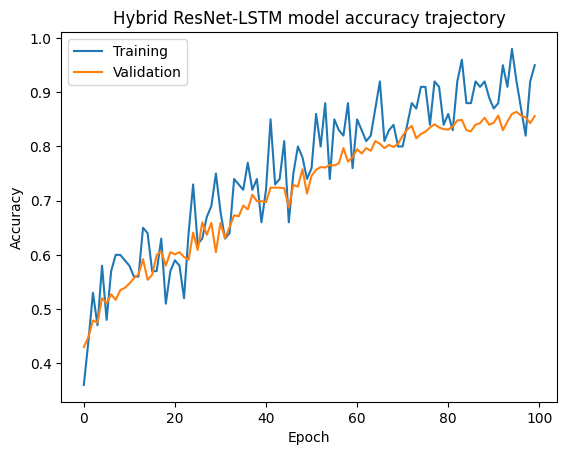

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


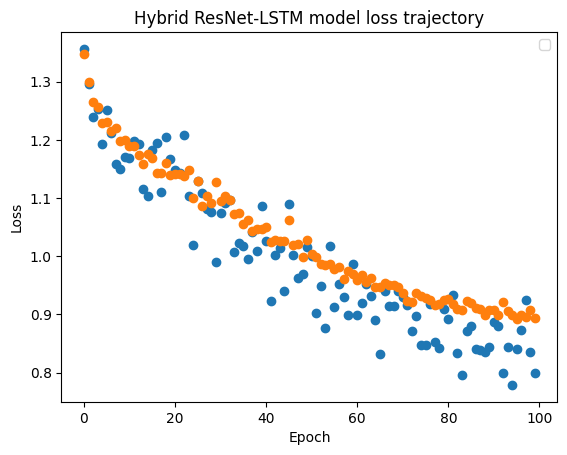

In [10]:
plt.plot(np.arange(100),train_history,label='Training')
plt.plot(np.arange(100),val_history,label='Validation')
plt.title('Hybrid ResNet-LSTM model accuracy trajectory')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(np.arange(100),train_loss_hist,'o')
plt.plot(np.arange(100),val_loss_hist,'o')
plt.title('Hybrid ResNet-LSTM model loss trajectory')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [23]:
model.eval()
test_count = 0
test_correct_count = 0
with torch.no_grad():
    test_x = x_test
    test_y = y_test
    logits = model(test_x).detach()
    logits = nn.functional.softmax(logits)
    test_loss = criterion(logits.float(), test_y.float())
    with torch.no_grad():
        y_hat = torch.argmax(logits, dim=1)
        test_correct_count = torch.sum(y_hat == torch.argmax(test_y, dim=1))
        test_count = float(test_x.size(0))
test_acc = test_correct_count / test_count
print('Test accuracy of the hybrid ResNet-LSTM model: ', test_acc.item())

C:\Users\awong\AppData\Local\Temp\ipykernel_14752\95673719.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)


Test accuracy of the hybrid ResNet-LSTM model:  0.5282167196273804
